In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that o

In [2]:
triplexes = pd.read_csv('basetriples_bal1.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,120,R.G.15.R.A.22.R.G.64.,-_-_-,7.01_31.43_27.35,1,0,0,0,0,...,0,0,0,0,0,0,0,7,3,0
1,1b23.cif1_R,123,R.A.13.R.G.15.R.A.46.,-_-_-,10.88_14.44_12.47,1,0,0,0,0,...,0,0,0,0,0,0,0,5,1,0
2,1b23.cif1_R,111,R.4SU.8.R.A.14.R.A.46.,tWH_t.W_cSS,10.04_12.76_4.86,0,0,1,0,0,...,0,0,0,0,0,0,0,5,1,1
3,1b23.cif1_R,111,R.4SU.8.R.G.15.R.G.48.,-_t.W_cSS,12.32_13.49_4.06,0,0,1,0,0,...,0,0,0,0,0,0,0,5,0,1
4,1b23.cif1_R,111,R.A.9.R.A.13.R.A.22.,tHW_tSH_-,11.7_10.01_13.84,0,0,1,1,0,...,0,0,0,0,0,0,0,4,0,1


In [4]:
triplexes.shape

(10700, 477)

In [3]:
### !!!!! необходимые данные

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [4]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    
    
    
def probability_density(y_prob, y):
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')
    plt.show()


In [5]:
#используемая модель
rf_classifier_cv = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

TEST_GROUPS Counter({'3j7q.cif1_5': 380, '3j79.cif1_A': 282, '3j7p.cif1_S2': 224, '6ha1.cif1_a': 188, '5o5j.cif1_A': 166, '3jam.cif1_2': 149, '5mrc.cif1_aa': 125, '3j9m.cif1_AA': 93, '5oql.cif1_1': 44, '4v9f.cif1_9': 22, '3igi.cif1_A': 20, '4r4v.cif1_A': 19, '3pdr.cif1_X': 18, '5t5h.cif1_D': 18, '4oqu.cif1_A': 16, '1yfg.cif1_A': 15, '4plx.cif1_A': 13, '2qwy.cif1_C': 11, '3u4m.cif1_B': 11, '4mgn.cif1_A': 11, '3v7e.cif1_C': 10, '3wqy.cif1_C': 10, '4prf.cif1_B': 10, '4y1j.cif1_A': 10, '5l4o.cif1_A': 10, '3d0u.cif1_A': 9, '3la5.cif1_A': 9, '3w3s.cif1_B': 9, '4aob.cif1_A': 9, '4jf2.cif1_A': 9, '5mgp.cif1_x': 9, '5oql.cif1_2': 9, '5u3g.cif1_B': 9, '5xxb.cif1_4': 9, '6az3.cif1_3': 9, '3j7q.cif1_8': 8, '4m4o.cif1_B': 8, '4qei.cif1_C': 8, '5b63.cif1_D': 8, '5mmm.cif1_z': 8, '5t5h.cif1_C': 8, '1h3e.cif1_B': 7, '1y26.cif1_X': 7, '3npq.cif1_A': 7, '3q3z.cif1_V': 7, '4m6d.cif1_H': 7, '1s03.cif1_B': 6, '2il9.cif1_A': 6, '2zue.cif1_B': 6, '4jxz.cif1_B': 6, '5ah5.cif1_D': 6, '5kk5.cif1_B': 6, '3dd2.ci

112 A.U.2968.A.C.2985.A.A.2988. -_-_cWW 19.11_14.57_10.5 PROBA:  0.5565498310686223
112 A.U.1597.A.A.2019.A.A.2649. -_-_tWH 69.76_61.87_9.75 PROBA:  0.5788010363425155
110 A.A.2386.A.G.3320.A.C.3329. -_cWW_- 93.87_10.51_100.92 PROBA:  0.6689401473073839
110 A.G.2427.A.C.2439.A.C.3258. cWW_-_- 10.71_81.67_85.31 PROBA:  0.517308520370126
CONFUSION MATRIX By chain:  3j79.cif1_A
[[140   4]
 [  8 130]]

CONFUSION MATRIX By chain:  4v9q.cif1_DV
[[1 0]
 [0 1]]

CONFUSION MATRIX By chain:  5t5h.cif1_D
[[9 0]
 [0 9]]

CONFUSION MATRIX By chain:  1h3e.cif1_B
[[5 0]
 [0 2]]

120 C.C.57.C.G.58.C.A.79. -_-_- 5.91_25.69_22.46 PROBA:  0.5567056297624857
CONFUSION MATRIX By chain:  5t5h.cif1_C
[[4 1]
 [0 3]]

CONFUSION MATRIX By chain:  3add.cif1_C
[[2 0]
 [0 1]]

123 C.G.35.C.A.94.C.U.96. -_-_- 19.74_11.96_27.41 PROBA:  0.8072390767322497
111 C.A.24.C.U.96.C.A.117. -_cWW_tWS 10.93_10.29_9.25 PROBA:  0.29918657218412437
CONFUSION MATRIX By chain:  3v7e.cif1_C
[[4 1]
 [1 4]]

CONFUSION MATRIX By chain:

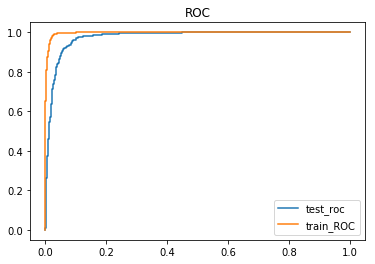

Probability density for train


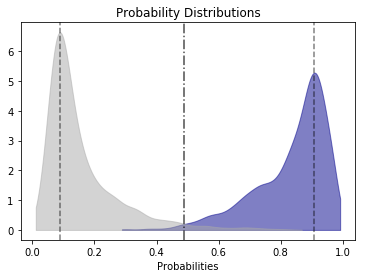

Probability density for test


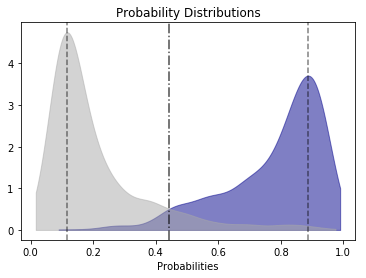


[[1050   78]
 [  77  935]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1050    78  1128
1            77   935  1012
All        1127  1013  2140


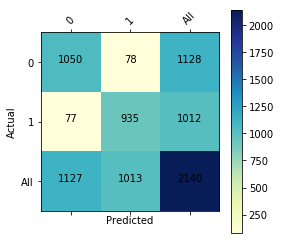


REPORT
             precision    recall  f1-score   support

          0       0.93      0.93      0.93      1128
          1       0.92      0.92      0.92      1012

avg / total       0.93      0.93      0.93      2140

ACCURACY =  0.927570093457944
-----------------
TEST_GROUPS Counter({'4v9f.cif1_0': 333, '4ioa.cif1_X': 285, '5mrc.cif1_A': 239, '5xy3.cif1_1': 223, '6ek0.cif1_S2': 163, '3j7a.cif1_A': 142, '5ngm.cif1_Aa': 137, '5t5h.cif1_B': 82, '5t2a.cif1_B': 77, '5ml7.cif1_B': 20, '5j7l.cif1_DB': 19, '5xy3.cif1_3': 18, '6d90.cif1_4': 17, '1c0a.cif1_B': 15, '5xxb.cif1_3': 14, '5ccb.cif1_N': 12, '2r8s.cif1_R': 11, '4wj4.cif1_B': 11, '1j1u.cif1_B': 10, '3f2x.cif1_X': 10, '3j79.cif1_C': 10, '4pr6.cif1_B': 10, '4uyk.cif1_R': 10, '5tbw.cif1_4': 10, '2azx.cif1_D': 9, '2d6f.cif1_F': 9, '2xdb.cif1_G': 9, '3al0.cif1_E': 9, '3kfu.cif1_L': 9, '3ski.cif1_A': 9, '4mgn.cif1_B': 9, '4qk9.cif1_A': 9, '5wwt.cif1_C': 9, '6cb3.cif1_B': 9, '1n78.cif1_C': 8, '4fen.cif1_B': 8, '4tue.cif1_QV': 8, '4znp.c

111 B.A.326.B.G.1331.B.U.1349. tWS_cWW_- 8.44_10.76_7.7 PROBA:  0.4387838215196055
110 B.U.324.B.A.1212.B.G.1224. -_tHS_- 71.9_9.37_65.11 PROBA:  0.5225778782003456
110 B.U.617.B.U.1295.B.C.1299. -_tW._- 91.08_10.85_95.25 PROBA:  0.5964035783738229
CONFUSION MATRIX By chain:  5t2a.cif1_B
[[39  2]
 [ 1 35]]

110 B.G.17.B.G.20.B.A.21. -_-_- 7.15_6.96_4.79 PROBA:  0.8271728156999224
CONFUSION MATRIX By chain:  5xtm.cif1_B
[[2 1]
 [0 2]]

120 A.C.14.A.G.16.A.A.23. -_-_- 10.34_8.38_14.55 PROBA:  0.6127659683252116
123 A.G.6.A.G.7.A.C.8. -_-_- 5.64_5.32_10.48 PROBA:  0.5110803212248514
CONFUSION MATRIX By chain:  1l2x.cif1_A
[[0 2]
 [0 1]]

123 A.A.532.A.A.2710.A.G.2711. -_-_- 69.65_5.32_68.51 PROBA:  0.5445822660577542
111 A.A.231.A.A.244.A.G.587. tHH_-_cSS 10.97_16.54_5.81 PROBA:  0.47500071627320783
111 A.U.703.A.A.1229.A.U.1257. cWW_-_cSW 10.65_11.14_6.35 PROBA:  0.46973986392981765
111 A.U.857.A.U.1187.A.A.1216. -_cWW_tWS 7.08_10.6_7.26 PROBA:  0.4759623469179228
111 A.C.1230.A.U.1257.A

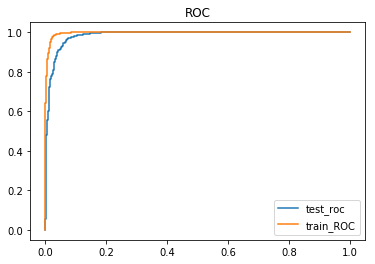

Probability density for train


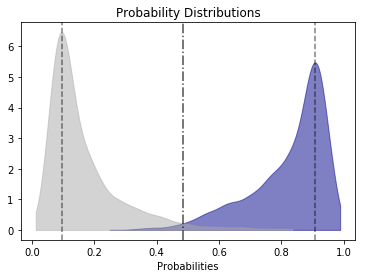

Probability density for test


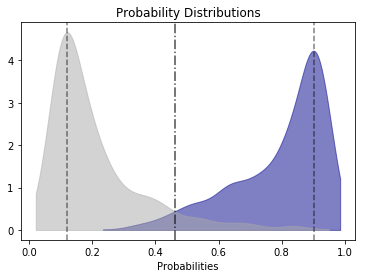


[[1056   69]
 [  55  960]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1056    69  1125
1            55   960  1015
All        1111  1029  2140


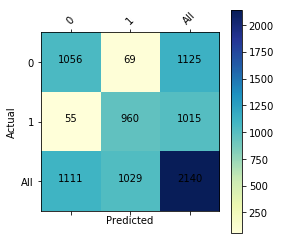


REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.94      1125
          1       0.93      0.95      0.94      1015

avg / total       0.94      0.94      0.94      2140

ACCURACY =  0.9420560747663551
-----------------
TEST_GROUPS Counter({'4y4o.cif1_2A': 321, '6eri.cif1_AA': 295, '5xxb.cif1_1': 247, '6d9j.cif1_5': 210, '6az1.cif1_1': 173, '5xxu.cif1_2': 139, '5xyi.cif1_2': 127, '5t5h.cif1_A': 103, '1u6b.cif1_B': 27, '1u9s.cif1_A': 23, '2a64.cif1_A': 20, '6az3.cif1_8': 20, '6ha1.cif1_B': 19, '4ycp.cif1_B': 18, '4wf9.cif1_Y': 17, '5lys.cif1_B': 15, '5fjc.cif1_A': 13, '5tbw.cif1_AS': 12, '5e6m.cif1_C': 11, '6d9j.cif1_7': 11, '4lck.cif1_F': 10, '4rdx.cif1_C': 10, '5hr6.cif1_C': 10, '5hr7.cif1_D': 10, '6d9j.cif1_8': 10, '6gaz.cif1_AV': 10, '1ser.cif1_T': 9, '2gdi.cif1_X': 9, '4jrc.cif1_B': 9, '4rzd.cif1_A': 9, '5aj0.cif1_Bv': 9, '5mrc.cif1_bb': 9, '5zwn.cif1_P': 9, '6cfj.cif1_1x': 9, '6ek0.cif1_S6': 9, '1il2.cif1_C': 8, '1qu2.cif1_T': 8,

111 A.G.13.A.C.26.A.U.59. cWW_-_cSS 10.74_8.76_6.68 PROBA:  0.49149999699805114
CONFUSION MATRIX By chain:  3d2v.cif1_A
[[4 0]
 [1 3]]

111 2.A.10.2.A.952.2.A.1108. cWW_tSW_cWS 12.17_9.05_5.6 PROBA:  0.3700111665637473
111 2.U.30.2.A.399.2.A.516. tWH_cWS_- 9.59_9.51_8.37 PROBA:  0.46857311767651744
111 2.U.62.2.A.75.2.A.140. cWW_cSW_- 10.05_6.76_11.31 PROBA:  0.43700835840505037
111 2.A.707.2.G.745.2.A.808. cWW_tSS_- 13.22_4.9_11.47 PROBA:  0.47242987411682413
111 2.A.1011.2.G.1360.2.A.1403. tWS_-_tHW 10.03_6.46_12.38 PROBA:  0.4478861615619711
111 2.A.1154.2.U.1187.2.C.1324. cWW_cSW_- 10.99_8.42_12.7 PROBA:  0.45734126990313945
112 2.G.783.2.C.785.2.A.1403. cSH_-_- 7.98_131.9_136.23 PROBA:  0.5066991240056631
112 2.G.816.2.C.828.2.A.1222. cWW_-_- 10.78_60.31_69.74 PROBA:  0.5481578174338795
CONFUSION MATRIX By chain:  5xyi.cif1_2
[[64  2]
 [ 6 55]]

CONFUSION MATRIX By chain:  5hr7.cif1_D
[[6 0]
 [0 4]]

CONFUSION MATRIX By chain:  5tbw.cif1_AS
[[5 0]
 [0 7]]

CONFUSION MATRIX By chai

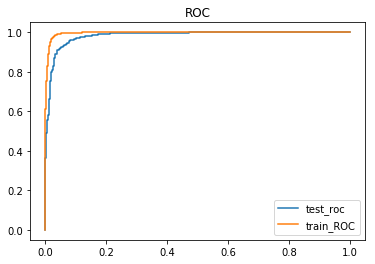

Probability density for train


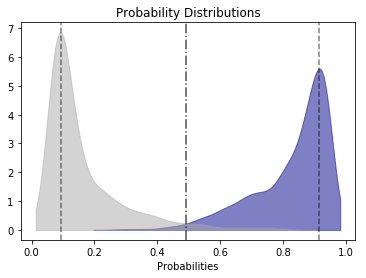

Probability density for test


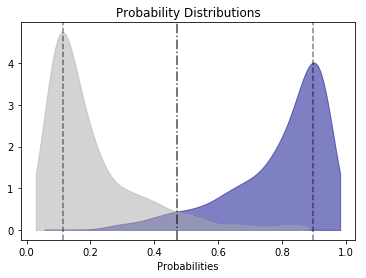


[[1060   66]
 [  73  941]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1060    66  1126
1            73   941  1014
All        1133  1007  2140


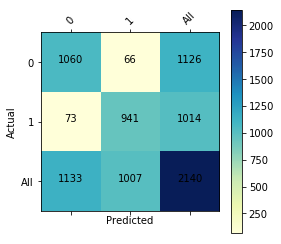


REPORT
             precision    recall  f1-score   support

          0       0.94      0.94      0.94      1126
          1       0.93      0.93      0.93      1014

avg / total       0.94      0.94      0.94      2140

ACCURACY =  0.9350467289719626
-----------------
TEST_GROUPS Counter({'5j7l.cif1_DA': 318, '6ha1.cif1_A': 297, '5tbw.cif1_1': 272, '5j7l.cif1_AA': 186, '5ool.cif1_A': 166, '6gaw.cif1_BA': 160, '6az3.cif1_1': 116, '6az3.cif1_2': 82, '6gaz.cif1_AA': 82, '4ioa.cif1_Y': 20, '4gxy.cif1_A': 19, '4kqy.cif1_A': 18, '4yaz.cif1_R': 18, '6ek0.cif1_L7': 15, '4qk8.cif1_A': 14, '3hhn.cif1_E': 13, '2der.cif1_D': 11, '5t83.cif1_A': 11, '1h4s.cif1_T': 10, '2qus.cif1_A': 10, '3dil.cif1_A': 10, '4p5j.cif1_A': 10, '4v8n.cif1_CV': 10, '6gaw.cif1_BB': 10, '1i6u.cif1_C': 9, '1u0b.cif1_A': 9, '4gcw.cif1_B': 9, '4v9k.cif1_AW': 9, '4yye.cif1_C': 9, '5aox.cif1_C': 9, '5e81.cif1_2K': 9, '6az3.cif1_7': 9, '6ck5.cif1_A': 9, '3amu.cif1_B': 8, '3oxe.cif1_A': 8, '4y1m.cif1_B': 8, '5jup.cif1_EC': 8, 

0 B.C.141.B.U.151.B.G.159. -_-_- 17.68_13.99_26.31 PROBA:  0.644800433141271
CONFUSION MATRIX By chain:  3lqx.cif1_B
[[1 1]
 [0 1]]

120 B.G.12.B.G.65.B.A.72. -_-_- 15.95_23.07_28.75 PROBA:  0.5163328622230511
123 B.A.11.B.G.12.B.C.101. -_-_- 7.98_19.47_21.11 PROBA:  0.6274943580533624
111 B.G.8.B.U.48.B.C.101. cWW_tWS_cWW 8.2_7.99_10.59 PROBA:  0.4397089037762668
112 B.G.8.B.U.13.B.A.98. -_tWH_- 12.83_9.39_13.88 PROBA:  0.5346586407012408
CONFUSION MATRIX By chain:  4y1m.cif1_B
[[2 3]
 [1 2]]

112 AA.U.1070.AA.A.1105.AA.C.1403. cWW_-_- 10.56_47.78_37.73 PROBA:  0.5285674795969575
112 AA.G.577.AA.C.764.AA.U.863. cWW_-_- 10.43_37.64_28.74 PROBA:  0.8039749878523763
110 AA.A.197.AA.U.291.AA.A.309. -_cWW_- 50.35_10.59_45.45 PROBA:  0.5651540668193299
CONFUSION MATRIX By chain:  5j7l.cif1_AA
[[90  3]
 [ 0 93]]

123 B.U.8.B.G.19.B.A.21. -_-_tSW 18.91_11.94_9.39 PROBA:  0.6708168439488239
112 B.U.8.B.G.15.B.A.21. -_-_tSW 9.97_8.45_9.39 PROBA:  0.6923839926772419
CONFUSION MATRIX By chain:  4

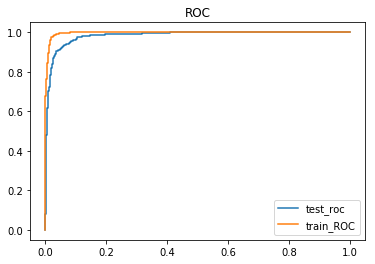

Probability density for train


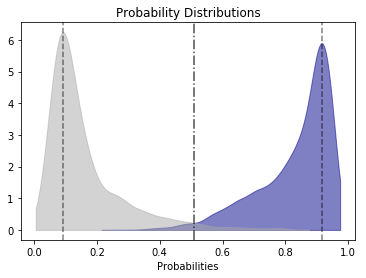

Probability density for test


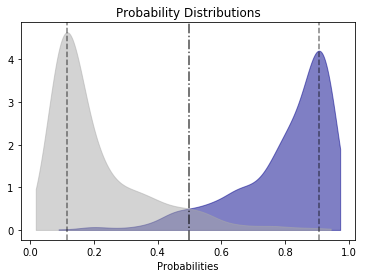


[[1048   80]
 [  61  951]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1048    80  1128
1            61   951  1012
All        1109  1031  2140


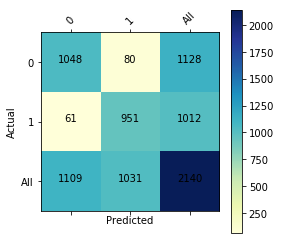


REPORT
             precision    recall  f1-score   support

          0       0.94      0.93      0.94      1128
          1       0.92      0.94      0.93      1012

avg / total       0.93      0.93      0.93      2140

ACCURACY =  0.9341121495327103
-----------------
TEST_GROUPS Counter({'5o60.cif1_A': 299, '6ek0.cif1_L5': 298, '4wf9.cif1_X': 273, '4v88.cif1_A6': 188, '4lfb.cif1_A': 174, '6eri.cif1_BA': 160, '5an9.cif1_N': 119, '6d9j.cif1_2': 115, '4p95.cif1_A': 25, '1nbs.cif1_B': 21, '3j7o.cif1_7': 20, '3j79.cif1_B': 19, '5fdv.cif1_1B': 19, '5xym.cif1_B': 18, '6eri.cif1_Ax': 16, '3mxh.cif1_R': 14, '3ivk.cif1_M': 13, '1mfq.cif1_A': 11, '4yco.cif1_D': 11, '5wt1.cif1_C': 11, '1qtq.cif1_B': 10, '3ndb.cif1_M': 10, '4qlm.cif1_A': 10, '5axm.cif1_P': 10, '6az3.cif1_5': 10, '6eri.cif1_AB': 10, '1evv.cif1_A': 9, '1y27.cif1_X': 9, '3eph.cif1_E': 9, '3iwn.cif1_A': 9, '3skl.cif1_B': 9, '4lx6.cif1_A': 9, '5ool.cif1_B': 9, '5xy3.cif1_4': 9, '6az3.cif1_4': 9, '2du3.cif1_D': 8, '3ivn.cif1_A': 8, '

CONFUSION MATRIX By chain:  4pqv.cif1_A
[[2]]

CONFUSION MATRIX By chain:  4nlf.cif1_A
[[1]]

123 A.C.2487.A.G.2500.A.G.2671. -_-_- 14.22_30.24_43.2 PROBA:  0.6582642208108537
111 A.G.267.A.A.359.A.C.514. tSS_-_cWW 8.21_6.19_11.04 PROBA:  0.4812927067048388
111 A.G.1072.A.C.1079.A.G.2474. cWW_-_tSW 10.43_9.36_10.93 PROBA:  0.45642141336905495
112 A.A.2161.A.U.2970.A.A.2982. -_tWH_- 88.31_11.25_89.32 PROBA:  0.6160484463871204
112 A.A.2683.A.U.2717.A.A.2838. cWW_-_- 10.91_43.32_49.3 PROBA:  0.5368517964159321
112 A.C.2366.A.G.2371.A.C.2725. cWW_-_- 10.37_114.05_106.59 PROBA:  0.5237064595494773
112 A.G.974.A.A.1032.A.A.1166. -_-_- 10.56_62.04_69.29 PROBA:  0.5328207176835149
110 A.C.1167.A.C.2904.A.G.2951. -_cWW_- 85.43_10.66_87.51 PROBA:  0.5115950242750342
110 A.A.1144.A.C.1430.A.G.1452. -_cWW_- 102.6_10.97_104.68 PROBA:  0.6879949457663613
110 A.U.448.A.U.2302.A.A.2465. -_cWW_- 80.12_10.43_80.67 PROBA:  0.5610228160455271
CONFUSION MATRIX By chain:  5o60.cif1_A
[[142   8]
 [  2 147]]

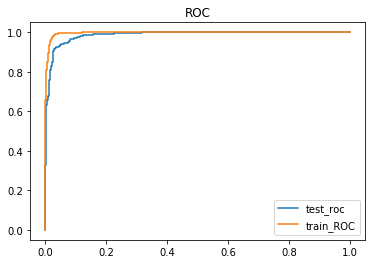

Probability density for train


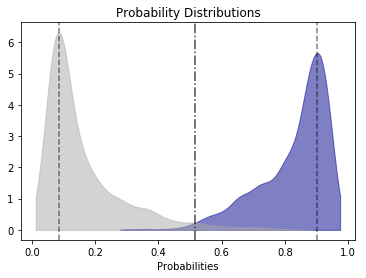

Probability density for test


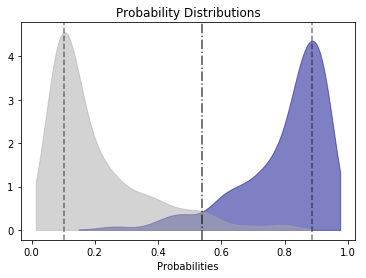


[[1038   81]
 [  55  966]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1038    81  1119
1            55   966  1021
All        1093  1047  2140


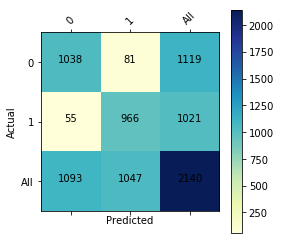


REPORT
             precision    recall  f1-score   support

          0       0.95      0.93      0.94      1119
          1       0.92      0.95      0.93      1021

avg / total       0.94      0.94      0.94      2140

ACCURACY =  0.9364485981308411
-----------------


In [6]:
groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=5)
#group_kfold.get_n_splits(X, y, groups)

description = ['type', 'dssrs', 'bps', 'dists']

for train_index, test_index in group_kfold.split(triplexes, triplexes_target, groups):
    #triplexes_data = triplexes.iloc[:, 5:475]
    #print(triplexes_data)
    X_train_middle, X_test_middle = triplexes.loc[list(train_index)], triplexes.loc[test_index]
    X_train = X_train_middle.iloc[:, 5:475]
    X_test = X_test_middle.iloc[:, 5:475]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]

    
    a = Counter(list(triplexes.loc[list(train_index)].pdb_chain.values))
    b = Counter(list(triplexes.loc[list(test_index)].pdb_chain.values))
    
    for key in a:
        if key in b.keys():
            print("FUUUUUUUUU")
    print("TEST_GROUPS", Counter(list(triplexes.pdb_chain.loc[test_index])))
    rf_classifier_cv.fit(X_train, y_train)
    
    #prediction by chains
    chains = list(set(X_test_middle.pdb_chain.values))

    print("")
    for chain in chains:
        middle_check_test = X_test_middle.loc[X_test_middle['pdb_chain'] == chain]
        middle_target_test = middle_check_test['istriple']
        middle_check_test_ = middle_check_test.iloc[:, 5:475]
    
        prediction_result_by_chain = rf_classifier_cv.predict(middle_check_test_)
        predict_proba_by_chain = rf_classifier_cv.predict_proba(middle_check_test_)

        
        #PREDICTED PROBABILITIES
        i = 0
        for index, row in middle_check_test.iterrows():
            if middle_target_test[index] != prediction_result_by_chain[i]:
                print(row['type'], row['dssrs'], row['bps'], row['dists'], "PROBA: ", predict_proba_by_chain[i][1])
            i = i + 1

        print("CONFUSION MATRIX By chain: ", chain)
        print(confusion_matrix(middle_target_test, prediction_result_by_chain))
        print("")
    
    #simple prediction
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY = ", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.9966334985769535

AUC =  0.9858667021604506


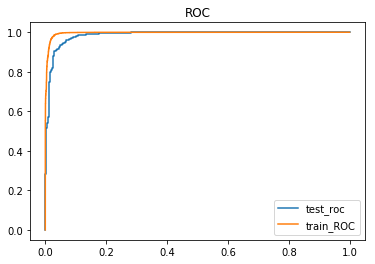

Probability density for train


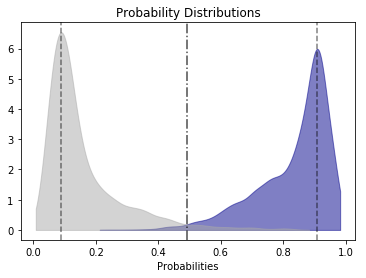

Probability density for test


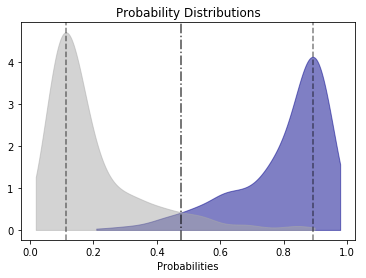


[[528  34]
 [ 27 481]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          528   34   562
1           27  481   508
All        555  515  1070


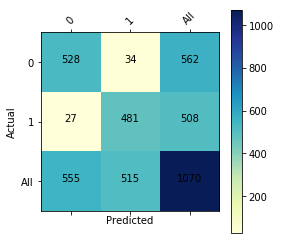

REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       562
          1       0.93      0.95      0.94       508

avg / total       0.94      0.94      0.94      1070

ACCURACY 0.9429906542056075
-----------------

AUC_TRAIN =  0.996235506251398

AUC =  0.9747463612152263


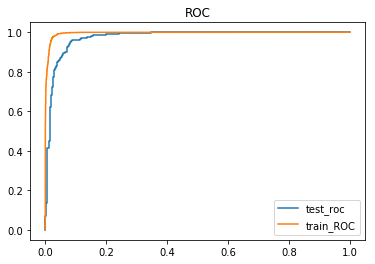

Probability density for train


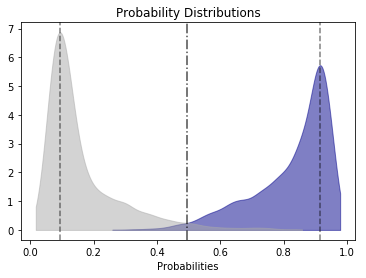

Probability density for test


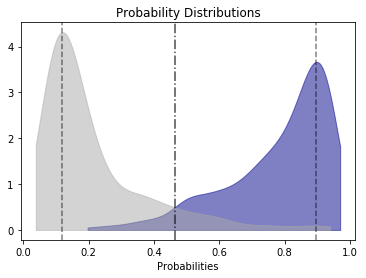


[[516  41]
 [ 37 476]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          516   41   557
1           37  476   513
All        553  517  1070


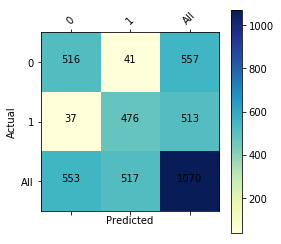

REPORT
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       557
          1       0.92      0.93      0.92       513

avg / total       0.93      0.93      0.93      1070

ACCURACY 0.9271028037383178
-----------------

AUC_TRAIN =  0.9959536335628509

AUC =  0.9865802155436783


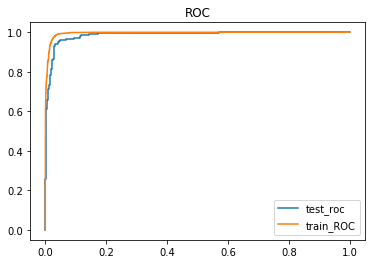

Probability density for train


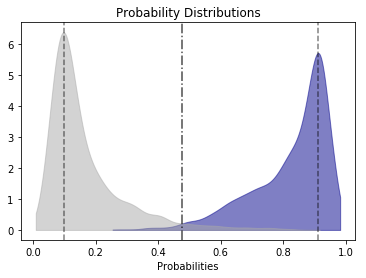

Probability density for test


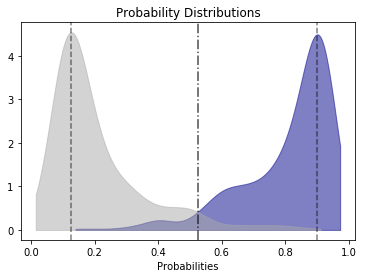


[[530  35]
 [ 21 484]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          530   35   565
1           21  484   505
All        551  519  1070


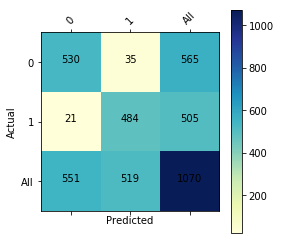

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       565
          1       0.93      0.96      0.95       505

avg / total       0.95      0.95      0.95      1070

ACCURACY 0.9476635514018692
-----------------

AUC_TRAIN =  0.9965432056469727

AUC =  0.9850612624649792


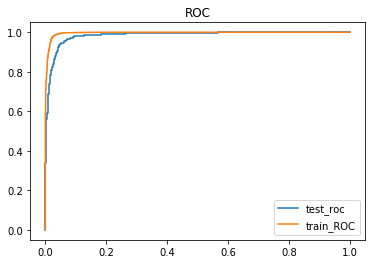

Probability density for train


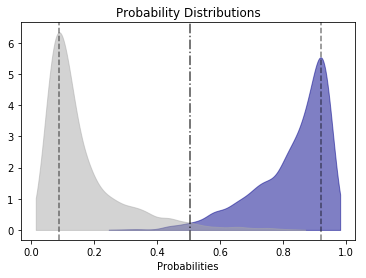

Probability density for test


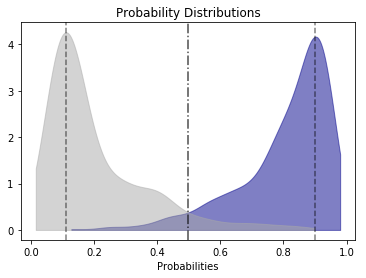


[[519  34]
 [ 24 493]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          519   34   553
1           24  493   517
All        543  527  1070


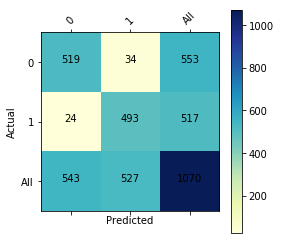

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       553
          1       0.94      0.95      0.94       517

avg / total       0.95      0.95      0.95      1070

ACCURACY 0.9457943925233645
-----------------

AUC_TRAIN =  0.9963121400636896

AUC =  0.9839130815736441


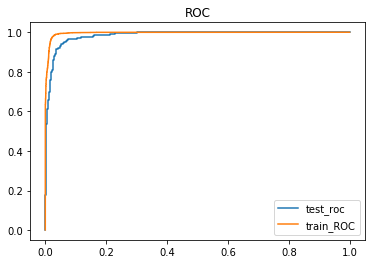

Probability density for train


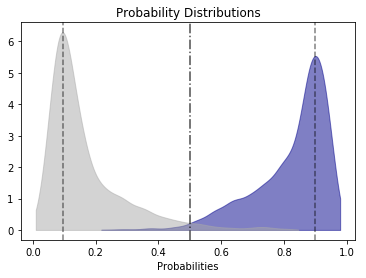

Probability density for test


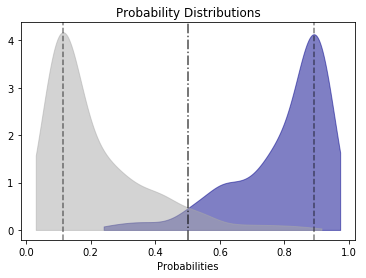


[[528  37]
 [ 25 480]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          528   37   565
1           25  480   505
All        553  517  1070


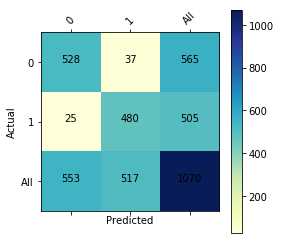

REPORT
             precision    recall  f1-score   support

          0       0.95      0.93      0.94       565
          1       0.93      0.95      0.94       505

avg / total       0.94      0.94      0.94      1070

ACCURACY 0.9420560747663551
-----------------

AUC_TRAIN =  0.9966545712247199

AUC =  0.9789551930042321


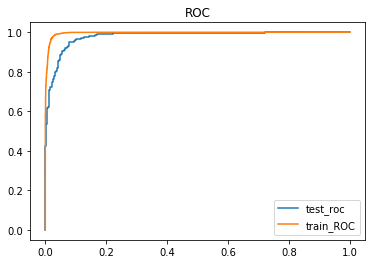

Probability density for train


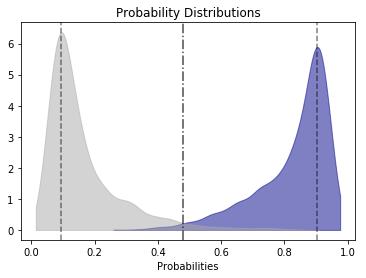

Probability density for test


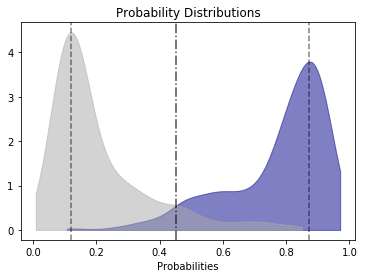


[[531  36]
 [ 42 461]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          531   36   567
1           42  461   503
All        573  497  1070


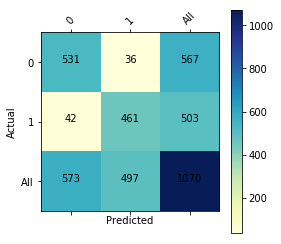

REPORT
             precision    recall  f1-score   support

          0       0.93      0.94      0.93       567
          1       0.93      0.92      0.92       503

avg / total       0.93      0.93      0.93      1070

ACCURACY 0.9271028037383178
-----------------

AUC_TRAIN =  0.9962637842606448

AUC =  0.9837904537551181


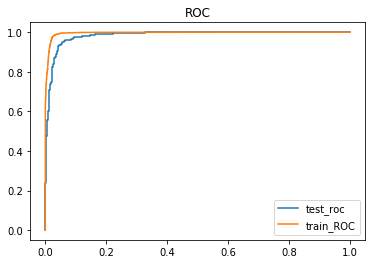

Probability density for train


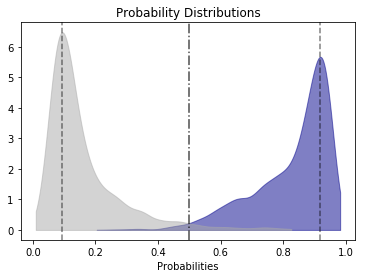

Probability density for test


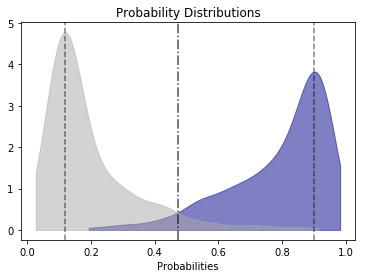


[[535  31]
 [ 29 475]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          535   31   566
1           29  475   504
All        564  506  1070


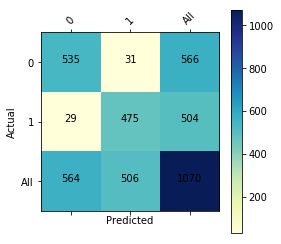

REPORT
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       566
          1       0.94      0.94      0.94       504

avg / total       0.94      0.94      0.94      1070

ACCURACY 0.9439252336448598
-----------------

AUC_TRAIN =  0.9965811982075984

AUC =  0.9815093136585142


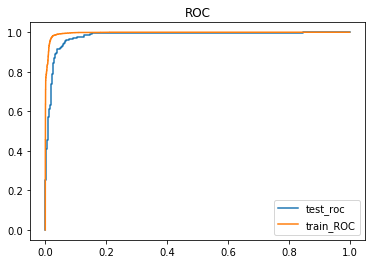

Probability density for train


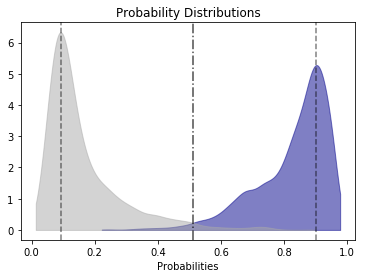

Probability density for test


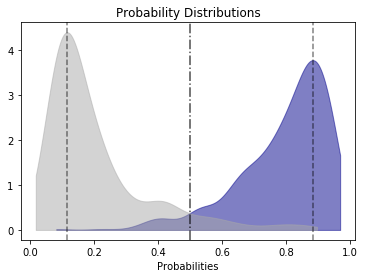


[[524  39]
 [ 20 487]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          524   39   563
1           20  487   507
All        544  526  1070


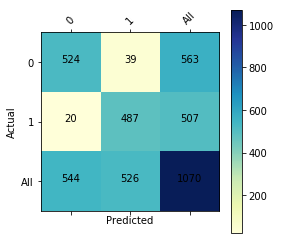

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.95       563
          1       0.93      0.96      0.94       507

avg / total       0.95      0.94      0.94      1070

ACCURACY 0.9448598130841122
-----------------

AUC_TRAIN =  0.996672441060171

AUC =  0.9856350567757279


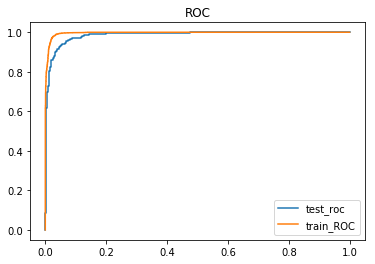

Probability density for train


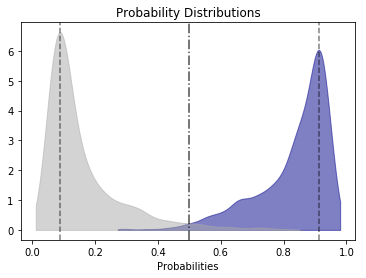

Probability density for test


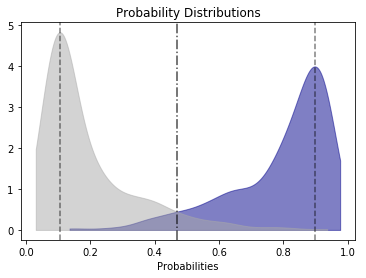


[[540  29]
 [ 34 467]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          540   29   569
1           34  467   501
All        574  496  1070


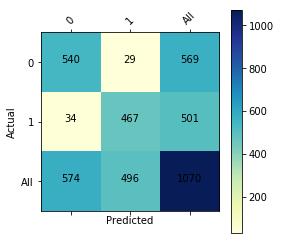

REPORT
             precision    recall  f1-score   support

          0       0.94      0.95      0.94       569
          1       0.94      0.93      0.94       501

avg / total       0.94      0.94      0.94      1070

ACCURACY 0.9411214953271028
-----------------

AUC_TRAIN =  0.9962349357530849

AUC =  0.9823909763380932


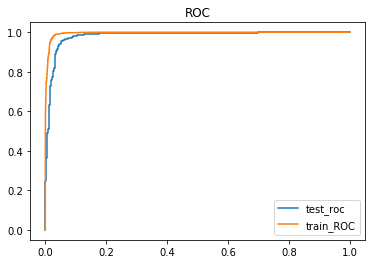

Probability density for train


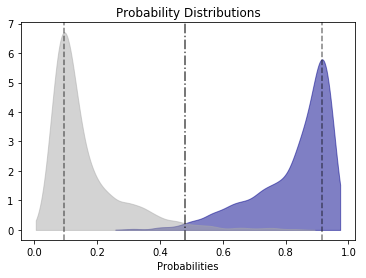

Probability density for test


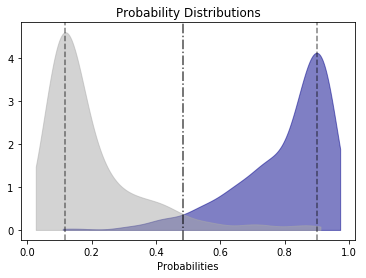


[[528  31]
 [ 23 488]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          528   31   559
1           23  488   511
All        551  519  1070


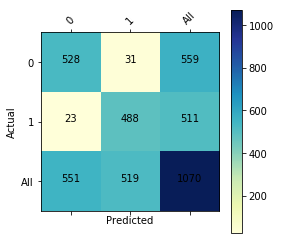

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       559
          1       0.94      0.95      0.95       511

avg / total       0.95      0.95      0.95      1070

ACCURACY 0.9495327102803738
-----------------


In [7]:
# 10 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=10)
#group_kfold.get_n_splits(X, y, groups)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.996460726777157

AUC =  0.9833009678205561


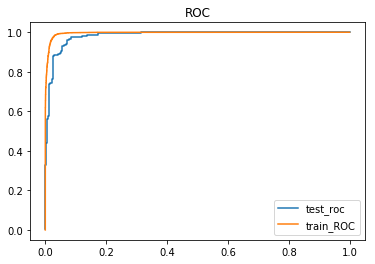

Probability density for train


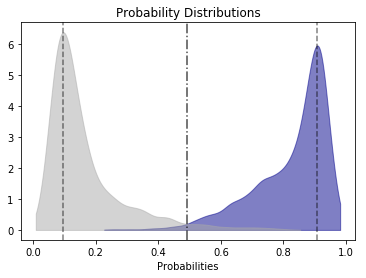

Probability density for test


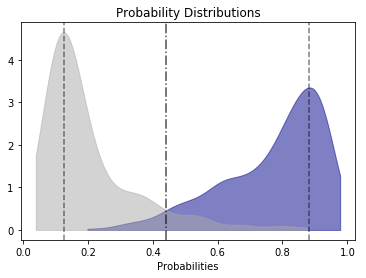


[[351  22]
 [ 24 317]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          351   22  373
1           24  317  341
All        375  339  714


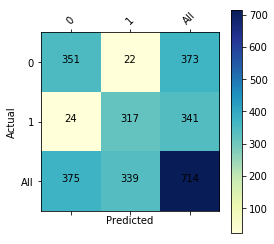

REPORT
             precision    recall  f1-score   support

          0       0.94      0.94      0.94       373
          1       0.94      0.93      0.93       341

avg / total       0.94      0.94      0.94       714

ACCURACY 0.9355742296918768
-----------------

AUC_TRAIN =  0.9963518790708543

AUC =  0.9881927236971485


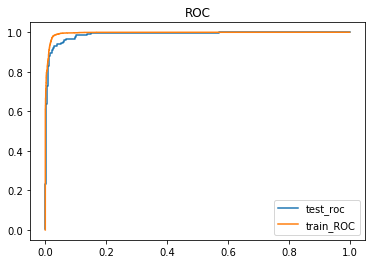

Probability density for train


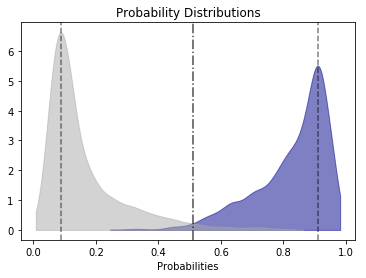

Probability density for test


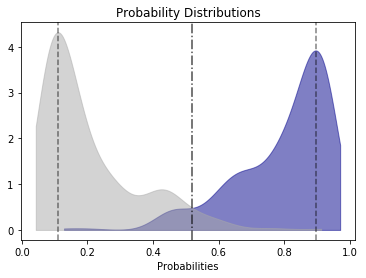


[[356  19]
 [ 19 320]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          356   19  375
1           19  320  339
All        375  339  714


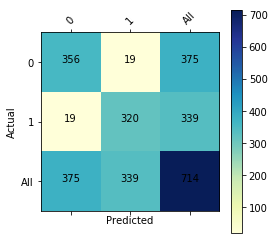

REPORT
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       375
          1       0.94      0.94      0.94       339

avg / total       0.95      0.95      0.95       714

ACCURACY 0.9467787114845938
-----------------

AUC_TRAIN =  0.9959392294079795

AUC =  0.9869775273826009


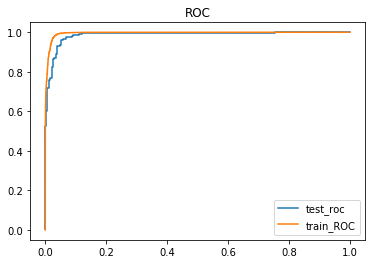

Probability density for train


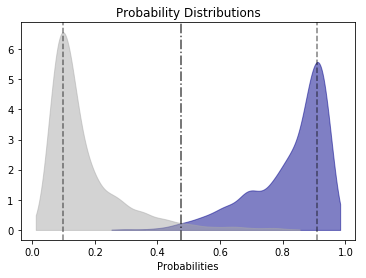

Probability density for test


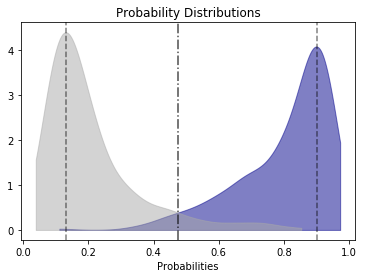


[[356  20]
 [ 15 323]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          356   20  376
1           15  323  338
All        371  343  714


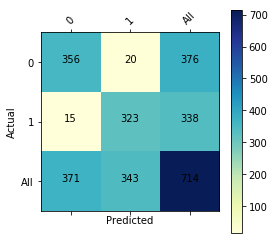

REPORT
             precision    recall  f1-score   support

          0       0.96      0.95      0.95       376
          1       0.94      0.96      0.95       338

avg / total       0.95      0.95      0.95       714

ACCURACY 0.9509803921568627
-----------------

AUC_TRAIN =  0.9965522556866164

AUC =  0.9794116488796125


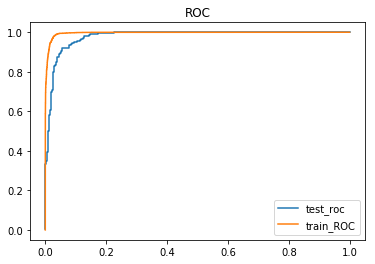

Probability density for train


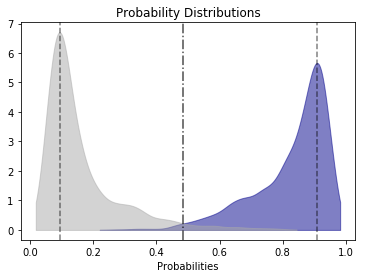

Probability density for test


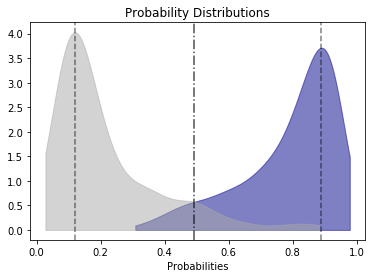


[[349  30]
 [ 23 312]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          349   30  379
1           23  312  335
All        372  342  714


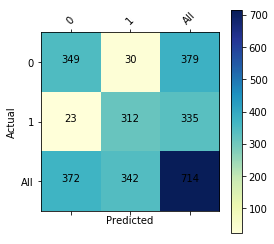

REPORT
             precision    recall  f1-score   support

          0       0.94      0.92      0.93       379
          1       0.91      0.93      0.92       335

avg / total       0.93      0.93      0.93       714

ACCURACY 0.9257703081232493
-----------------

AUC_TRAIN =  0.9960457701303057

AUC =  0.9857692701241253


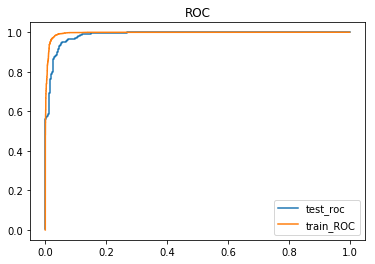

Probability density for train


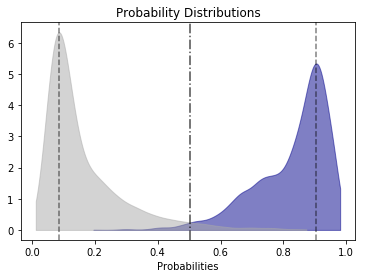

Probability density for test


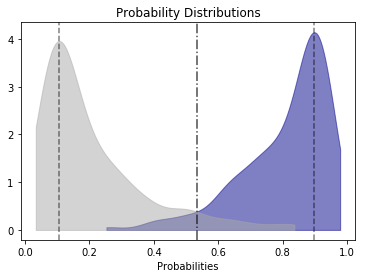


[[349  28]
 [ 14 323]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          349   28  377
1           14  323  337
All        363  351  714


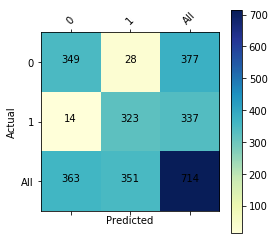

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.94       377
          1       0.92      0.96      0.94       337

avg / total       0.94      0.94      0.94       714

ACCURACY 0.9411764705882353
-----------------

AUC_TRAIN =  0.9963724631995986

AUC =  0.9885003150598612


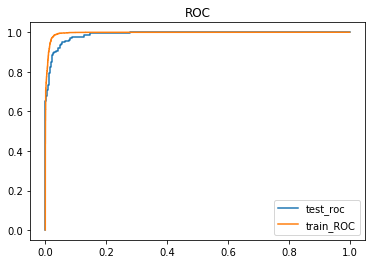

Probability density for train


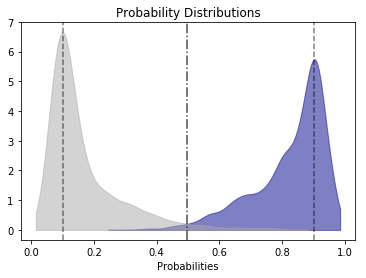

Probability density for test


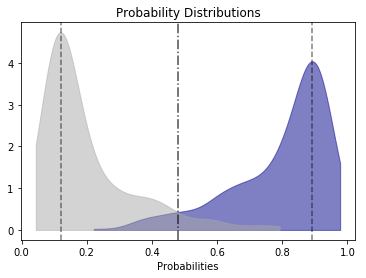


[[349  19]
 [ 23 322]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          349   19  368
1           23  322  345
All        372  341  713


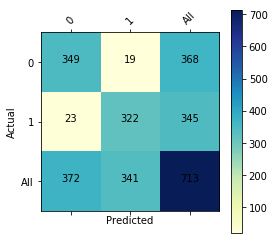

REPORT
             precision    recall  f1-score   support

          0       0.94      0.95      0.94       368
          1       0.94      0.93      0.94       345

avg / total       0.94      0.94      0.94       713

ACCURACY 0.94109396914446
-----------------

AUC_TRAIN =  0.996517908662304

AUC =  0.9815329250584003


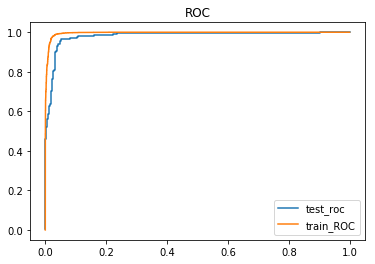

Probability density for train


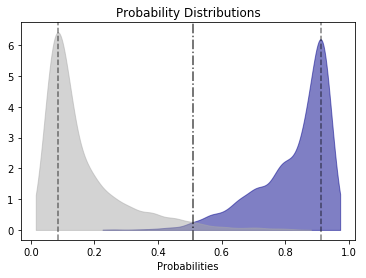

Probability density for test


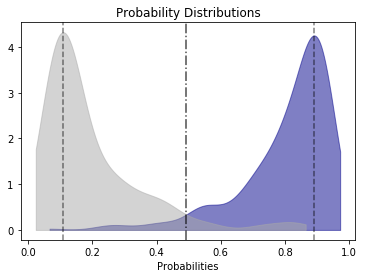


[[357  19]
 [ 14 323]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          357   19  376
1           14  323  337
All        371  342  713


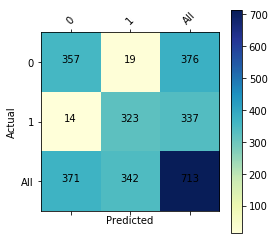

REPORT
             precision    recall  f1-score   support

          0       0.96      0.95      0.96       376
          1       0.94      0.96      0.95       337

avg / total       0.95      0.95      0.95       713

ACCURACY 0.9537166900420757
-----------------

AUC_TRAIN =  0.9960396899494105

AUC =  0.983165594931509


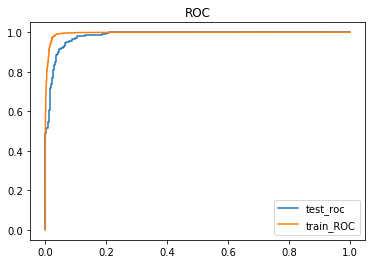

Probability density for train


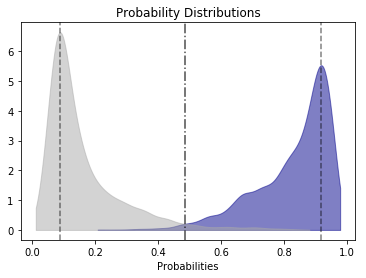

Probability density for test


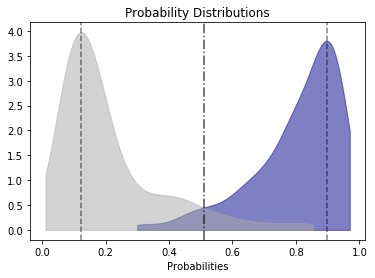


[[349  30]
 [ 15 319]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          349   30  379
1           15  319  334
All        364  349  713


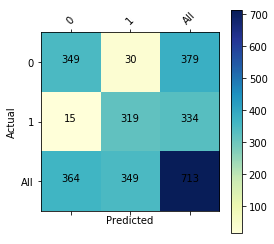

REPORT
             precision    recall  f1-score   support

          0       0.96      0.92      0.94       379
          1       0.91      0.96      0.93       334

avg / total       0.94      0.94      0.94       713

ACCURACY 0.9368863955119214
-----------------

AUC_TRAIN =  0.9960285878622861

AUC =  0.9832189349112426


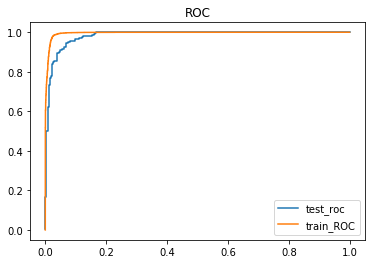

Probability density for train


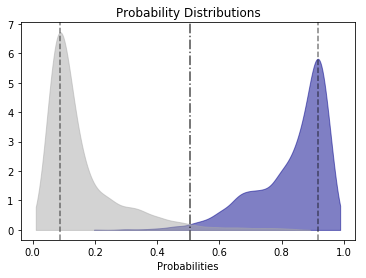

Probability density for test


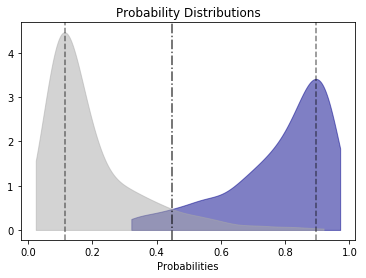


[[353  22]
 [ 28 310]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          353   22  375
1           28  310  338
All        381  332  713


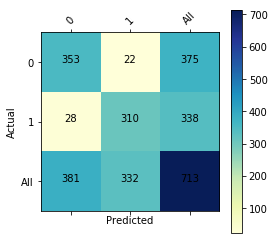

REPORT
             precision    recall  f1-score   support

          0       0.93      0.94      0.93       375
          1       0.93      0.92      0.93       338

avg / total       0.93      0.93      0.93       713

ACCURACY 0.9298737727910238
-----------------

AUC_TRAIN =  0.9962409401168109

AUC =  0.9895589999368646


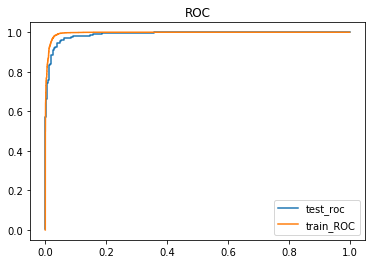

Probability density for train


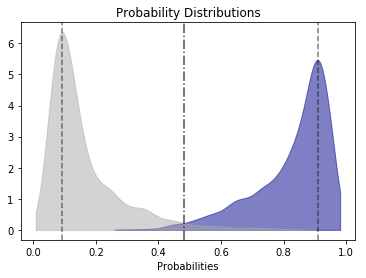

Probability density for test


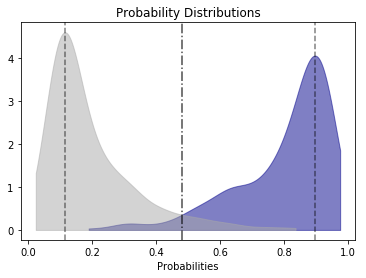


[[357  19]
 [ 15 322]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          357   19  376
1           15  322  337
All        372  341  713


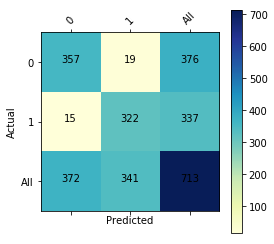

REPORT
             precision    recall  f1-score   support

          0       0.96      0.95      0.95       376
          1       0.94      0.96      0.95       337

avg / total       0.95      0.95      0.95       713

ACCURACY 0.9523141654978962
-----------------

AUC_TRAIN =  0.9964811641411931

AUC =  0.9839763313609469


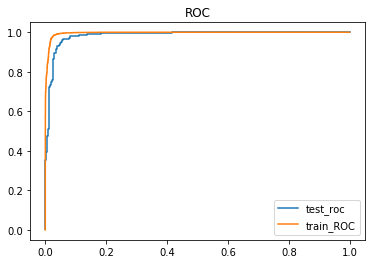

Probability density for train


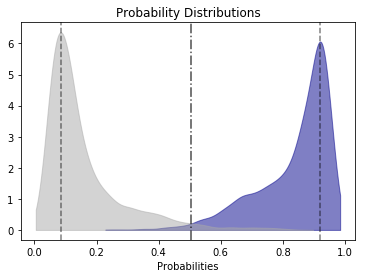

Probability density for test


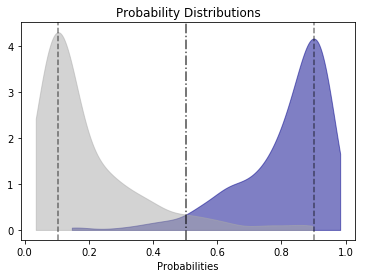


[[351  24]
 [ 12 326]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          351   24  375
1           12  326  338
All        363  350  713


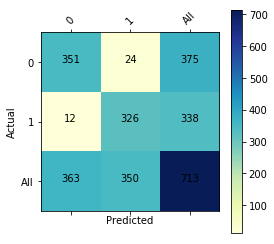

REPORT
             precision    recall  f1-score   support

          0       0.97      0.94      0.95       375
          1       0.93      0.96      0.95       338

avg / total       0.95      0.95      0.95       713

ACCURACY 0.9495091164095372
-----------------

AUC_TRAIN =  0.9959807943581517

AUC =  0.9795172370328356


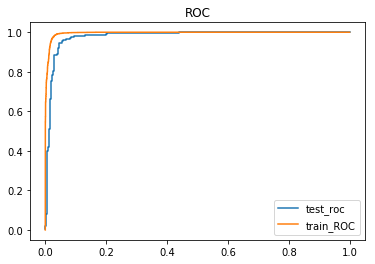

Probability density for train


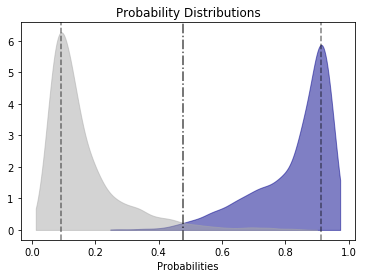

Probability density for test


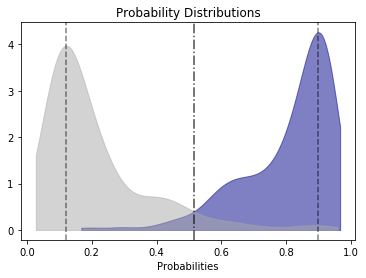


[[344  25]
 [ 13 331]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          344   25  369
1           13  331  344
All        357  356  713


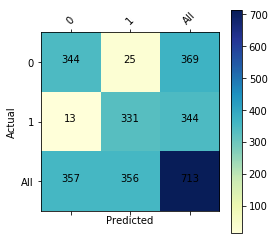

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.95       369
          1       0.93      0.96      0.95       344

avg / total       0.95      0.95      0.95       713

ACCURACY 0.9467040673211781
-----------------

AUC_TRAIN =  0.9964480406324208

AUC =  0.9888534277092254


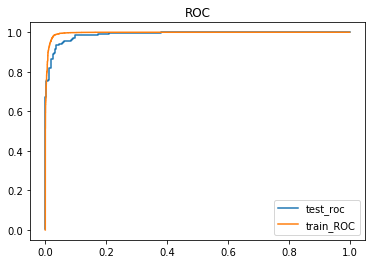

Probability density for train


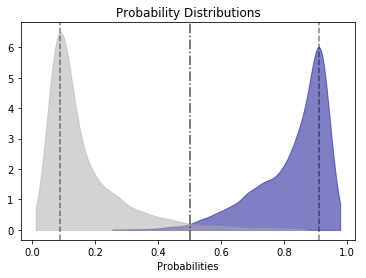

Probability density for test


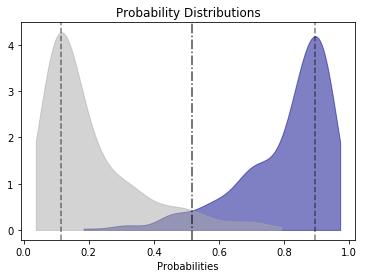


[[356  23]
 [ 16 318]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          356   23  379
1           16  318  334
All        372  341  713


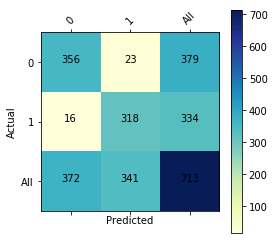

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       379
          1       0.93      0.95      0.94       334

avg / total       0.95      0.95      0.95       713

ACCURACY 0.9453015427769986
-----------------

AUC_TRAIN =  0.9965442484032838

AUC =  0.9790119953972982


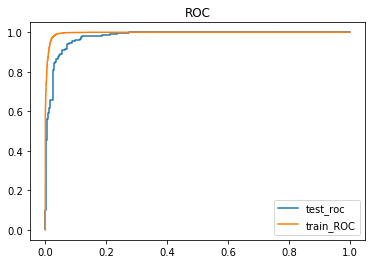

Probability density for train


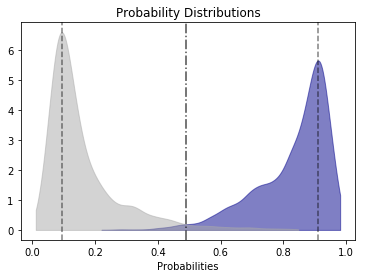

Probability density for test


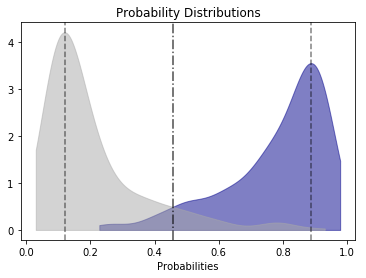


[[344  27]
 [ 27 315]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          344   27  371
1           27  315  342
All        371  342  713


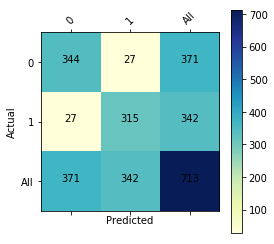

REPORT
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       371
          1       0.92      0.92      0.92       342

avg / total       0.92      0.92      0.92       713

ACCURACY 0.9242636746143057
-----------------

AUC_TRAIN =  0.996427341043958

AUC =  0.9783779515122798


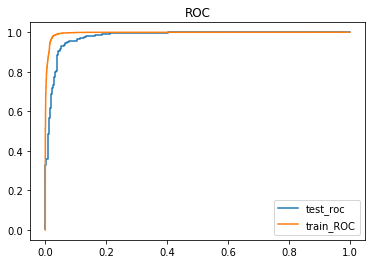

Probability density for train


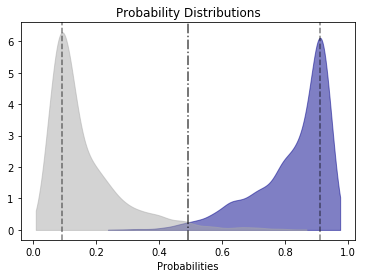

Probability density for test


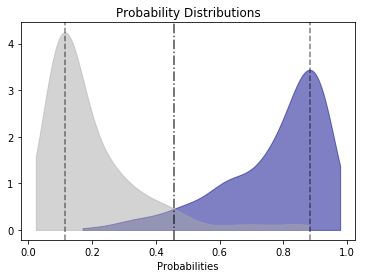


[[359  19]
 [ 27 308]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          359   19  378
1           27  308  335
All        386  327  713


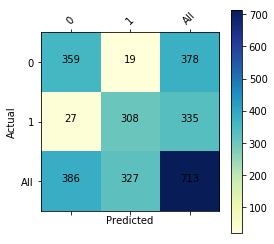

REPORT
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       378
          1       0.94      0.92      0.93       335

avg / total       0.94      0.94      0.94       713

ACCURACY 0.9354838709677419
-----------------


In [8]:
# 15 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=15)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")
